In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import adjusted_rand_score

from pygraphs.cluster import KernelKMeans, Ward, KernelKMeansSklearn, KernelWardSklearn
from pygraphs.graphs.generators import StochasticBlockModel, StochasticBlockModel2, RubanovModel
from pygraphs.measure import *
from pygraphs.measure import H_kernels_plus_RSP_FE, scaler
from pygraphs.scenario import ParallelByGraphs, RejectCurve, plot_results

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


# 1.
Привлекает внимание Heat (p.4). Частично мы это уже обсуждали. Самое невероятное - что при p_out = 0.1 для абсолютного большинства графов Heat разделяет классы лучше, чем при p_out = 0.05. Т.е. при 0.05 просто нет графов, кот. разделяются так же хорошо, как большинство при 0.1. Как это возможно? Или лучшие графы при 0.05 дают переполнение и отбрасываются?
При p_out = 0.1 есть буквально 5 патологических графов. Что с ними происходит, почему Heat не справляется? Можно было бы предположить, что это графы, где плотность межклассовых связей существенно отклоняется вверх от 0.1.

In [3]:
graphs, info = StochasticBlockModel2(100, 2, 0.3, 0.1).generate_graphs(10)
print(info)

{'name': 'count:10, n:100, k:2, p_in:0.3, p_out:0.1', 'n_graphs': 10, 'n': 100, 'k': 2, 'p_in': 0.3, 'p_out': 0.1}


In [4]:
rc = RejectCurve([100], [2], [0.3], [0.05, 0.1, 0.15], [Heat_H], [Heat], StochasticBlockModel2, Ward)

In [5]:
rc.calc(10, 1)

calc data to find best params...



find best params...
(100, 2, 0.3, 0.1)	Heat H  	0.88 (0.94)
(100, 2, 0.3, 0.15)	Heat H  	0.66 (0.76)


{(100, 2, 0.3, 0.1): {'Heat H': 0.88}, (100, 2, 0.3, 0.15): {'Heat H': 0.66}}

In [17]:
results = rc.perform(100)

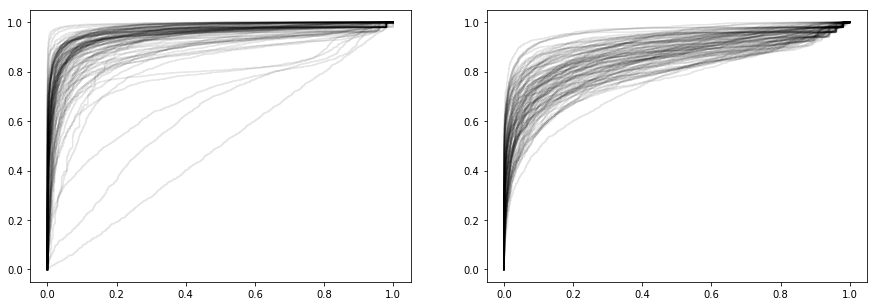

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for idx, column in enumerate([(100, 2, 0.3, 0.1), (100, 2, 0.3, 0.15)]):
    for tpr, fpr in results[column]['Heat H']:
        ax[idx].plot(tpr, fpr, color='black', alpha=0.1)